# Задание 4. Параллельные алгоритмы на графах

In [1]:
import numpy as np
from numba import cuda
np.random.seed(123)

In [2]:
def gen_matrix(N):
    W = [100000, 2, 3, 5, 8]
    is_symmetrical = True

    while (is_symmetrical):
        A = np.random.choice(W, (N,N))
        np.fill_diagonal(A, 0)
        if np.array_equal(A, A.T) == False:
            is_symmetrical = False
    return A

## Последовательно

### N = 100

In [3]:
N = 100
A = gen_matrix(N)

In [4]:
%%timeit
for k in range(N):
    for i in range(N):
        for j in range(N):
            A[i][j]=min(A[i][j], A[i][k]+A[k][j])

1.04 s ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### N = 150

In [5]:
N = 150
A = gen_matrix(N)

In [6]:
%%timeit
for k in range(N):
    for i in range(N):
        for j in range(N):
            A[i][j]=min(A[i][j], A[i][k]+A[k][j])

3.48 s ± 49.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### N = 200

In [7]:
N = 200
A = gen_matrix(N)

In [8]:
%%timeit
for k in range(N):
    for i in range(N):
        for j in range(N):
            A[i][j]=min(A[i][j], A[i][k]+A[k][j])

8.04 s ± 149 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Параллельно

In [9]:
@cuda.jit
def step_kernel(A, N, K):
  idx = cuda.grid(1)
  i = idx // N
  j = idx - i*N
  if idx < A.size:
    A[idx]=min(A[idx], A[i*N+K]+A[K*N+j])

### N = 100

In [10]:
N = 100
A = gen_matrix(N)
TBP = 1024
BPG = N*N// TBP + 1

In [11]:
%%timeit
A_device = cuda.to_device(A.flatten())

for k in range(N):
  step_kernel[BPG, TBP](A_device, N, k)
  
res = A_device.copy_to_host()

/home/bato/miniconda3/envs/p-numba/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


4.97 ms ± 551 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### N = 150

In [12]:
N = 150
A = gen_matrix(N)
TBP = 1024
BPG = N*N// TBP + 1

In [13]:
%%timeit
A_device = cuda.to_device(A.flatten())

for k in range(N):
  step_kernel[BPG, TBP](A_device, N, k)
  
res = A_device.copy_to_host()

/home/bato/miniconda3/envs/p-numba/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 22 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


8.22 ms ± 411 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### N = 200

In [14]:
N = 200
A = gen_matrix(N)
TBP = 1024
BPG = N*N// TBP + 1

In [15]:
%%timeit
A_device = cuda.to_device(A.flatten())

for k in range(N):
  step_kernel[BPG, TBP](A_device, N, k)
  
res = A_device.copy_to_host()

/home/bato/miniconda3/envs/p-numba/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 40 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


11.1 ms ± 222 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Сравнение результатов

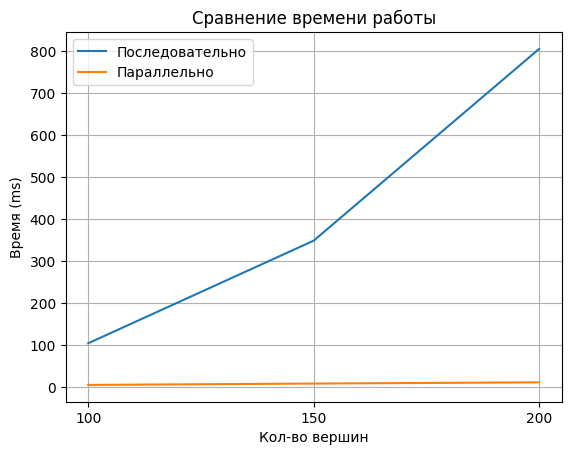

In [17]:
import matplotlib.pyplot as plt

ns = [100, 150, 200]
s_times = [104, 348, 804]
p_times = [4.97, 8.22, 11.1]

plt.plot(ns, s_times)
plt.plot(ns, p_times)
plt.title("Сравнение времени работы")
plt.xlabel("Кол-во вершин")
plt.ylabel("Время (ms)")
plt.grid(True)
plt.legend(['Последовательно', 'Параллельно'])
plt.xticks(ns)
plt.show()